# CoDA (uncertainty‑aware) — OSM Fig. 4c/4i/4j with **fixed plotting**

**Fixes in this version**
- Transition graph: angle‑aware, **radial label placement** (numbers sit next to their nodes);
- Clear **base / near(R1) / far(R2)** separation with correct z‑order and colors; near edges draw **on top**;
- **Fig. 4i** annotations no longer overlap (wider canvas + clamped text positions).

In [17]:

import math, random, collections
from dataclasses import dataclass
from typing import Dict, List, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle

try:
    from mpmath import betainc, erfcinv
    _HAS_MPMATH = True
except Exception:
    _HAS_MPMATH = False

random.seed(0); np.random.seed(0)


In [18]:

def posterior_prob_p_greater_than(theta: float, success: float, failure: float, alpha0: float=0.5, beta0: float=0.5) -> float:
    if not _HAS_MPMATH:
        return 0.0
    a = alpha0 + max(0.0, float(success))
    b = beta0 + max(0.0, float(failure))
    cdf = betainc(a, b, 0, theta, regularized=True)
    return float(1.0 - cdf)

def wilson_lower_bound(phat: float, n: float, confidence: float=0.95) -> float:
    if n <= 0:
        return 0.0
    if _HAS_MPMATH:
        z = float((2.0**0.5) * erfcinv(2*(1.0-confidence)))
    else:
        z = 1.6448536269514722  # ~95%
    denom = 1.0 + (z*z)/n
    center = phat + (z*z)/(2.0*n)
    adj = z * ((phat*(1.0-phat) + (z*z)/(4.0*n))/n)**0.5
    return (center - adj)/denom


In [19]:

near = [1,1,1,1,1,1, 2,2,2,2, 1,1,1, 4, 6, 1,1,1, 5,5, 1,1, 7, 0,0,0]
far  = [1,1,1,1,1,1, 3,3,3,3, 1,1,1, 4,4, 1,1,1, 5, 6, 1,1, 7, 0,0,0]
assert len(near)==len(far)==26

preR1_idx = list(range(10,13))
preR2_idx = list(range(15,18))

def block_indices(rows, cols): return [(r,c) for r in rows for c in cols]
offdiag_pairs     = block_indices(preR1_idx, preR2_idx) + block_indices(preR2_idx, preR1_idx)
same_preR1_pairs  = block_indices(preR1_idx, preR1_idx)
same_preR2_pairs  = block_indices(preR2_idx, preR2_idx)

symbols = sorted(set(near)|set(far))


In [20]:

@dataclass
class UncCfg:
    gamma: float = 0.9
    lam: float = 0.8
    theta_split: float = 0.9
    confidence: float = 0.95
    alpha0: float = 0.5
    beta0: float = 0.5
    n_threshold: int = 5
    min_presence_episodes: int = 3
    min_effective_exposure: float = 10.0
    reset_symbols: tuple = (0,)

class CoDAUncAgent:
    def __init__(self, obs_symbols, cfg: UncCfg=UncCfg()):
        self.cfg = cfg
        self.reset_symbols = set(cfg.reset_symbols)
        self.states: Dict[int, Dict] = {}
        self.obs_to_state_ids: Dict[int, List[int]] = {o: [] for o in obs_symbols}
        sid = 0
        for o in obs_symbols:
            self.states[sid] = {'obs': o, 'path': None, 'parent': None}
            self.obs_to_state_ids[o].append(sid); sid += 1
        self._next_sid = sid
        self.us_classes = [4,5]
        self.co_occ = {s: {u: 0.0 for u in self.us_classes} for s in self.states}
        self.exposure = {s: 0.0 for s in self.states}
        self.presence_episodes = {s: 0 for s in self.states}
        self.salient = {}
    
    def _ensure(self, sid):
        if sid not in self.co_occ:
            self.co_occ[sid] = {u: 0.0 for u in self.us_classes}
            self.exposure[sid] = 0.0
            self.presence_episodes[sid] = 0
    
    def _clone_state(self, orig_state_id: int, path: str) -> int:
        orig = self.states[orig_state_id]
        cid = self._next_sid
        self.states[cid] = {'obs': orig['obs'], 'path': path, 'parent': orig_state_id}
        self.obs_to_state_ids[orig['obs']].append(cid)
        self._ensure(cid)
        self._next_sid += 1
        return cid
    
    def _select_state_for_obs(self, obs: int, context: Optional[str]) -> int:
        cands = self.obs_to_state_ids[obs]
        if context is not None:
            for sid in cands:
                if self.states[sid]['path'] == context:
                    return sid
        for sid in cands:
            if self.states[sid]['path'] is None:
                return sid
        return cands[0]
    
    def run_episode(self, obs_seq: List[int], learn=True):
        context=None; latent_seq=[]; visited=set()
        for obs in obs_seq:
            sid = self._select_state_for_obs(obs, context)
            latent_seq.append(sid); visited.add(sid)
            if sid in self.salient: context=self.salient[sid]
            if obs in self.reset_symbols: context=None
        
        if not learn: return latent_seq
        
        for sid in visited: self.presence_episodes[sid] = self.presence_episodes.get(sid,0)+1
        
        us_positions = {4:[i for i,o in enumerate(obs_seq) if o==4],
                        5:[i for i,o in enumerate(obs_seq) if o==5]}
        for u, pos_list in us_positions.items():
            for t_us in pos_list:
                e = np.zeros(self._next_sid, dtype=float)
                for t in range(t_us+1):
                    sid = latent_seq[t]
                    e *= (self.cfg.gamma * self.cfg.lam)
                    e[sid]+=1.0
                for s_id, val in enumerate(e):
                    if val>0 and s_id in self.states:
                        self._ensure(s_id)
                        self.co_occ[s_id][u]+=val
                        self.exposure[s_id]+=val
        
        P = {}
        for s in self.states:
            tot = sum(self.co_occ[s][u] for u in self.us_classes)
            P[s] = {u:(self.co_occ[s][u]/tot if tot>0 else 0.0) for u in self.us_classes}
        
        newly_salient=[]
        for s in list(self.states.keys()):
            if s in self.salient: continue
            tot = sum(self.co_occ[s][u] for u in self.us_classes)
            if tot < self.cfg.n_threshold: continue
            if self.presence_episodes.get(s,0) < self.cfg.min_presence_episodes: continue
            if self.exposure.get(s,0.0) < self.cfg.min_effective_exposure: continue
            u_star = max(self.us_classes, key=lambda u: P[s][u])
            success = self.co_occ[s][u_star]; failure = tot - success
            phat = success / (tot if tot>0 else 1.0)
            post = posterior_prob_p_greater_than(self.cfg.theta_split, success, failure,
                                                 self.cfg.alpha0, self.cfg.beta0)
            pass_test = (post >= self.cfg.confidence) if post>0 else (wilson_lower_bound(phat, tot, self.cfg.confidence) > self.cfg.theta_split)
            if pass_test:
                path = 'R1' if u_star==4 else 'R2'
                self.salient[s]=path; newly_salient.append((s,path))
        
        for s,path in newly_salient:
            context=None
            for t,obs in enumerate(obs_seq[:-1]):
                sid = self._select_state_for_obs(obs, context)
                if sid==s:
                    nxt_obs = obs_seq[t+1]
                    cands = self.obs_to_state_ids[nxt_obs]
                    if not any(self.states[c]['path']==path for c in cands):
                        self._clone_state(cands[0], path)
                if sid in self.salient: context=self.salient[sid]
                if obs_seq[t+1] in self.reset_symbols: context=None
        
        return latent_seq
    
    def encode_sequence(self, obs_seq: List[int]) -> np.ndarray:
        lat = self.run_episode(obs_seq, learn=False)
        S = self._next_sid
        X = np.zeros((len(lat), S), dtype=float)
        for t, sid in enumerate(lat):
            X[t, sid]=1.0
        return X[:, :self._next_sid]
    
    def near_far_corr(self, near_seq, far_seq) -> np.ndarray:
        A=self.encode_sequence(near_seq); B=self.encode_sequence(far_seq)
        C=np.zeros((A.shape[0], B.shape[0]))
        for i in range(A.shape[0]):
            for j in range(B.shape[0]):
                a=A[i]; b=B[j]
                if np.allclose(a,0) or np.allclose(b,0): C[i,j]=0.0; continue
                a0=a-a.mean(); b0=b-b.mean()
                den=(np.linalg.norm(a0)*np.linalg.norm(b0))
                C[i,j]=(a0@b0)/den if den>0 else 0.0
        return C


In [21]:

N_RUNS   = 8
SESSIONS = 9
TRIALS_PER_SESSION = 80
THRESH   = 0.3

def block_mean(C, pairs): 
    return float(np.mean([C[i,j] for (i,j) in pairs])) if pairs else np.nan

rng = np.random.default_rng(123)
all_final_blocks=[]; all_time_to_thr=[]; mat_by_session={s:[] for s in [1,3,4,9]}
checkpoint_sessions=[1,3,4,9]; demo_checkpoints={}

for run in range(N_RUNS):
    agent = CoDAUncAgent(obs_symbols=sorted(set(near)|set(far)), cfg=UncCfg())
    tt={'offdiag':None,'preR2':None,'preR1':None}
    for session in range(1, SESSIONS+1):
        episodes = [near]*(TRIALS_PER_SESSION//2) + [far]*(TRIALS_PER_SESSION//2)
        rng.shuffle(episodes)
        for ep in episodes: agent.run_episode(ep, learn=True)
        C = agent.near_far_corr(near, far)
        if session in mat_by_session: mat_by_session[session].append(C)
        if run==0 and session in checkpoint_sessions:
            snap = CoDAUncAgent(obs_symbols=sorted(set(near)|set(far)), cfg=agent.cfg)
            snap.states={k:v.copy() for k,v in agent.states.items()}
            snap._next_sid=agent._next_sid
            snap.obs_to_state_ids={k:list(v) for k,v in agent.obs_to_state_ids.items()}
            snap.co_occ={k:dict(v) for k,v in agent.co_occ.items()}
            snap.exposure=dict(agent.exposure)
            snap.presence_episodes=dict(agent.presence_episodes)
            snap.salient=dict(agent.salient)
            demo_checkpoints[session]=snap
        b_off=block_mean(C, offdiag_pairs); b_r2=block_mean(C, same_preR2_pairs); b_r1=block_mean(C, same_preR1_pairs)
        if tt['offdiag'] is None and b_off<THRESH: tt['offdiag']=session
        if tt['preR2']  is None and b_r2<THRESH:  tt['preR2']=session
        if tt['preR1']  is None and b_r1<THRESH:  tt['preR1']=session
    C_final = agent.near_far_corr(near, far)
    all_final_blocks.append((run, block_mean(C_final, offdiag_pairs),
                                  block_mean(C_final, same_preR2_pairs),
                                  block_mean(C_final, same_preR1_pairs)))
    def norm(x): return x/SESSIONS if x is not None else np.nan
    all_time_to_thr.append((run, norm(tt['offdiag']), norm(tt['preR2']), norm(tt['preR1'])))

blocks_df=pd.DataFrame(all_final_blocks, columns=['run','offdiag','preR2','preR1']).set_index('run')
times_df =pd.DataFrame(all_time_to_thr, columns=['run','offdiag_t','preR2_t','preR1_t']).set_index('run')

display(blocks_df.describe()); display(times_df.describe())


,offdiag,preR2,preR1
count,8.000000,8.000000,8.000000e+00
mean,0.450568,-0.098864,1.000000e+00
std,0.001607,0.003214,8.392497e-17
min,0.450000,-0.100000,1.000000e+00
25%,0.450000,-0.100000,1.000000e+00
50%,0.450000,-0.100000,1.000000e+00
75%,0.450000,-0.100000,1.000000e+00
max,0.454545,-0.090909,1.000000e+00


,offdiag_t,preR2_t,preR1_t
count,0.0,8.000000,0.0
mean,NaN,0.222222,NaN
std,NaN,0.000000,NaN
min,NaN,0.222222,NaN
25%,NaN,0.222222,NaN
50%,NaN,0.222222,NaN
75%,NaN,0.222222,NaN
max,NaN,0.222222,NaN


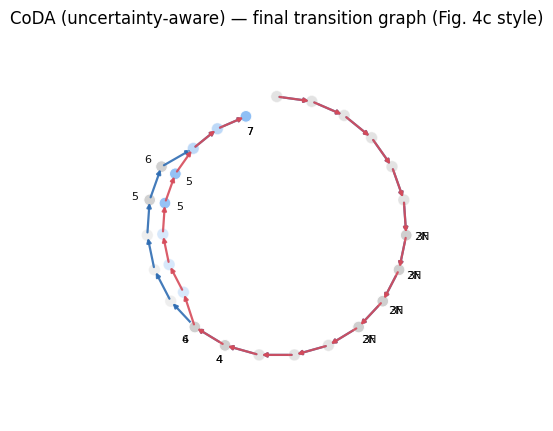

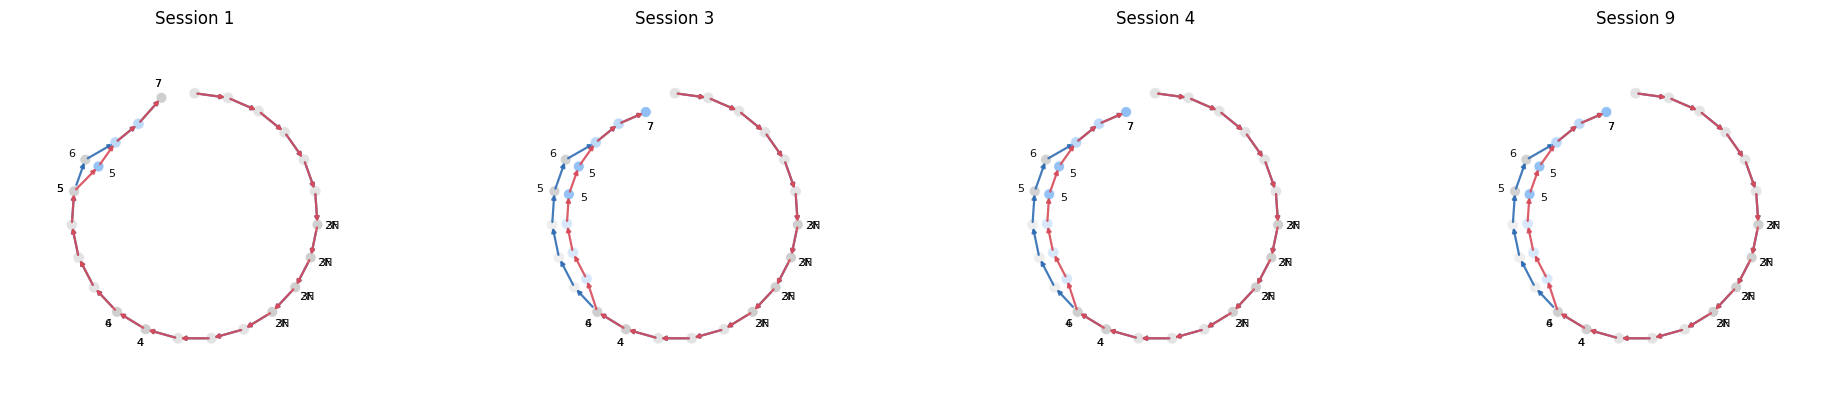

In [22]:

def canonical_latents(agent, seq):
    lat = agent.run_episode(seq, learn=False)
    out=[]
    for t,(obs,sid) in enumerate(zip(seq, lat)):
        if obs==0: break
        out.append((t, obs, sid, agent.states[sid]['path']))
    return out

def ring_positions(T: int, r_base=1.0, r_near=1.12, r_far=0.88, start_angle=np.pi/2):
    pos_by_t = {}
    for t in range(T):
        theta = start_angle - 2*np.pi*(t / max(T,1))
        pos_by_t[t] = {
            'theta': theta,
            'base': (r_base*np.cos(theta), r_base*np.sin(theta)),
            'R1':   (r_near*np.cos(theta), r_near*np.sin(theta)),
            'R2':   (r_far*np.cos(theta),  r_far*np.sin(theta)),
            'radii': {'base': r_base, 'R1': r_near, 'R2': r_far}
        }
    return pos_by_t

def draw_ring_graph(ax, agent, title=None, key_only=True):
    near_lat = canonical_latents(agent, near)
    far_lat  = canonical_latents(agent, far)
    T = max(len(near_lat), len(far_lat))
    pos = ring_positions(T)
    col_node = {None:'#cfcfcf','R1':'#ff9bb0','R2':'#8fbff5'}
    col_edge_near='#d64b5a'; col_edge_far='#2f6db3'
    
    def draw_nodes(lat_seq, z=2):
        for (t, obs, sid, path) in lat_seq:
            ring = 'base' if path is None else path
            x, y = pos[t][ring]
            circ = Circle((x,y), radius=0.045, facecolor=col_node[path], edgecolor='white', lw=0.7,
                          alpha=(0.35 if obs==1 else 0.95), zorder=z)
            ax.add_patch(circ)
            if key_only and obs in (2,3,4,5,6,7):
                theta = pos[t]['theta']
                r = pos[t]['radii'][ring]
                # place labels slightly **outside** the ring along the radial direction
                r_label = r + (0.12 if ring!='R2' else -0.12)
                lx, ly = (r_label*np.cos(theta), r_label*np.sin(theta))
                lbl = f'{obs if obs not in (2,3) else ("2N" if obs==2 else "3F")}'
                ax.text(lx, ly, lbl, ha='center', va='center', fontsize=8, color='k', alpha=0.95, zorder=4)
    
    def draw_edges(lat_seq, edge_color, z=3):
        for i in range(len(lat_seq)-1):
            t, obs, sid, path   = lat_seq[i]
            t2, obs2, sid2, p2 = lat_seq[i+1]
            ring  = 'base' if path is None else path
            ring2 = 'base' if p2   is None else p2
            x1,y1 = pos[t][ring]; x2,y2 = pos[t2][ring2]
            arr = FancyArrowPatch((x1,y1),(x2,y2), arrowstyle='-|>', mutation_scale=6,
                                  lw=1.6, color=edge_color, alpha=0.9, shrinkA=2, shrinkB=2, zorder=z)
            ax.add_patch(arr)
    
    # Draw far first, then near on top so red is visible
    draw_nodes(far_lat, z=2);  draw_edges(far_lat,  col_edge_far,  z=3)
    draw_nodes(near_lat, z=4); draw_edges(near_lat, col_edge_near, z=5)
    
    ax.set_aspect('equal'); ax.axis('off')
    ax.set_xlim(-1.5, 1.5); ax.set_ylim(-1.5, 1.5)
    if title: ax.set_title(title)

# Pick the last checkpoint as "final"
final_session = max([s for s in [1,3,4,9] if s in demo_checkpoints])
fig, ax = plt.subplots(figsize=(6.5,4.2), constrained_layout=True)
draw_ring_graph(ax, demo_checkpoints[final_session], title="CoDA (uncertainty‑aware) — final transition graph (Fig. 4c style)")
plt.show()

# Progression panels
fig, axes = plt.subplots(1, len(demo_checkpoints), figsize=(4.8*len(demo_checkpoints),4.0), constrained_layout=True)
for ax, s in zip(axes, sorted(demo_checkpoints.keys())):
    draw_ring_graph(ax, demo_checkpoints[s], title=f"Session {s}")
plt.show()


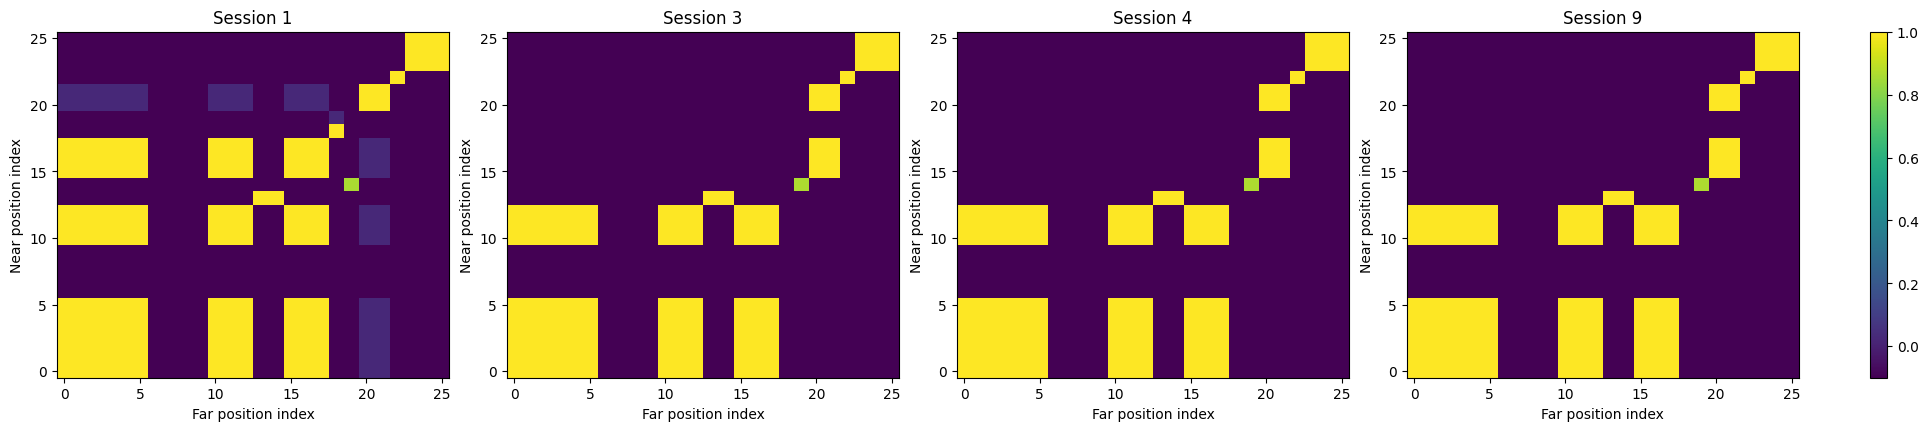

In [23]:

check_sessions = [1,3,4,9]
mean_mats = {s: np.mean(mat_by_session[s], axis=0) for s in check_sessions}

fig, axes = plt.subplots(1, len(check_sessions), figsize=(4.8*len(check_sessions),4.2), constrained_layout=True)
vmin, vmax = -0.1, 1.0
for ax, s in zip(axes, check_sessions):
    im = ax.imshow(mean_mats[s], vmin=vmin, vmax=vmax, origin='lower', aspect='auto')
    ax.set_title(f"Session {s}")
    ax.set_xlabel("Far position index")
    ax.set_ylabel("Near position index")
fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
plt.show()


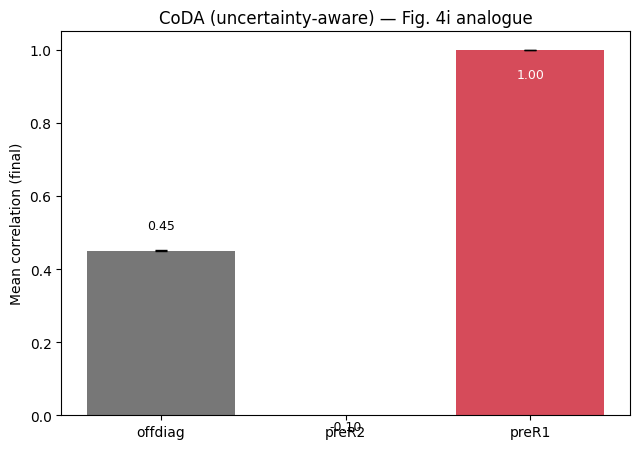

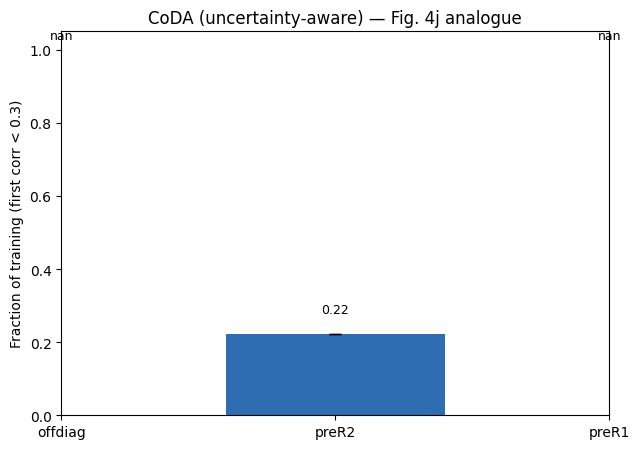

In [24]:

# Fig. 4i
means = blocks_df.mean(); ses = blocks_df.sem()
labels = ['offdiag','preR2','preR1']
x = np.arange(len(labels)); y = [means[l] for l in labels]; yerr = [ses[l] for l in labels]

fig, ax = plt.subplots(figsize=(6.5,4.6))
bars = ax.bar(x, y, yerr=yerr, capsize=4, color=['#777','#2f6db3','#d64b5a'])
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Mean correlation (final)")
ax.set_title("CoDA (uncertainty‑aware) — Fig. 4i analogue")

# Place labels inside bars when tall; above when short
for i, (b, val) in enumerate(zip(bars, y)):
    height = b.get_height()
    if height > 0.85:
        ax.text(b.get_x()+b.get_width()/2, height-0.05, f"{val:.2f}", ha='center', va='top', color='white', fontsize=9)
    else:
        ax.text(b.get_x()+b.get_width()/2, min(1.02, height+0.05), f"{val:.2f}", ha='center', va='bottom', fontsize=9)

fig.tight_layout()
plt.show()

# Fig. 4j
means_t = times_df.mean(skipna=True); ses_t = times_df.sem(skipna=True)
labels_t = ['offdiag_t','preR2_t','preR1_t']; disp = ['offdiag','preR2','preR1']
x = np.arange(len(labels_t)); y = [means_t[l] for l in labels_t]; yerr = [ses_t[l] for l in labels_t]

fig, ax = plt.subplots(figsize=(6.5,4.6))
bars = ax.bar(x, y, yerr=yerr, capsize=4, color=['#777','#2f6db3','#d64b5a'])
ax.set_xticks(x); ax.set_xticklabels(disp)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Fraction of training (first corr < 0.3)")
ax.set_title("CoDA (uncertainty‑aware) — Fig. 4j analogue")

for i, (b, val) in enumerate(zip(bars, y)):
    ax.text(b.get_x()+b.get_width()/2, min(1.02, b.get_height()+0.05), f"{val:.2f}", ha='center', va='bottom', fontsize=9)

fig.tight_layout()
plt.show()
